In [5]:
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt

def segment_and_label(frame_bgr, threshold=50, min_area=5):
    """
    Threshold + connected components segmentation.
    Returns:
       labels: 2D array, each pixel = component ID (0 = background)
       num_labels: total number of labels (including background)
    """
    gray = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2GRAY)
    _, bin_img = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)
    num_labels, labels = cv2.connectedComponents(bin_img)

    # Optional: filter out small components by setting them to background
    for label_id in range(1, num_labels):
        area = np.sum(labels == label_id)
        if area < min_area:
            labels[labels == label_id] = 0

    return labels

def create_random_color_map(num_labels):
    """
    Generates a random (B, G, R) color for each label ID [0..num_labels-1].
    label 0 (background) will be black.
    """
    color_map = []
    random.seed(42)
    for i in range(num_labels):
        if i == 0:
            color_map.append((0, 0, 0))  # background = black
        else:
            color_map.append((random.randint(50,255), random.randint(50,255), random.randint(50,255)))
    return color_map

def labels_to_color_image(labels):
    """
    Converts a 2D labels array into a color image (in BGR format).
    """
    h, w = labels.shape
    max_label = labels.max()
    if max_label < 1:
        # No actual nuclei except background
        seg_image = np.zeros((h, w, 3), dtype=np.uint8)
        return seg_image

    color_map = create_random_color_map(max_label + 1)
    seg_image = np.zeros((h, w, 3), dtype=np.uint8)

    for label_id in range(1, max_label + 1):
        seg_image[labels == label_id] = color_map[label_id]

    return seg_image

def visualize_segmentation(frame_bgr, threshold=50, min_area=5):
    """
    Segments the frame, returns (color_mask, count_of_nuclei).
    """
    labels = segment_and_label(frame_bgr, threshold=threshold, min_area=min_area)

    # Count how many unique labels > 0
    nucleus_ids = np.unique(labels)
    nucleus_ids = nucleus_ids[nucleus_ids > 0]  # skip label 0
    nucleus_count = len(nucleus_ids)

    color_mask = labels_to_color_image(labels)
    return color_mask, nucleus_count

def plot_side_by_side(frame_bgr, color_mask, nucleus_count, subtitle=""):
    """
    Show the original frame (converted to RGB) and the color-labeled mask side by side,
    with the count in the title.
    """
    frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(12, 6))
    plt.subplot(1,2,1)
    plt.imshow(frame_rgb)
    plt.title(f"Original Frame {subtitle}")
    plt.axis("off")

    plt.subplot(1,2,2)
    # Convert BGR color_mask to RGB for display
    color_mask_rgb = color_mask[..., ::-1]
    plt.imshow(color_mask_rgb)
    plt.title(f"Segmentation\nNuclei Count: {nucleus_count}")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

def show_first_last_segmentation(video_path, threshold=50, min_area=5):
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if frame_count < 2:
        print("Not enough frames in video:", video_path)
        return

    # Read first frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
    ret, first_frame = cap.read()
    if not ret:
        print("Could not read first frame!", video_path)
        return
    first_mask, first_count = visualize_segmentation(first_frame, threshold=threshold, min_area=min_area)

    # Read last frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_count - 1)
    ret, last_frame = cap.read()
    if not ret:
        print("Could not read last frame!", video_path)
        return
    last_mask, last_count = visualize_segmentation(last_frame, threshold=threshold, min_area=min_area)

    cap.release()

    print(f"\nVideo: {video_path}")
    print(f"First frame nuclei: {first_count}")
    print(f"Last frame nuclei: {last_count}")
    ratio = 0 if first_count == 0 else (last_count / first_count)
    print(f"Ratio: {ratio:.2f}")

    # Show them side by side
    plot_side_by_side(first_frame, first_mask, first_count, subtitle="(First Frame)")
    plot_side_by_side(last_frame, last_mask, last_count, subtitle="(Last Frame)")



Video: ../data/processed/idr0013/LT0001_02/00004_01.mp4
First frame nuclei: 73
Last frame nuclei: 303
Ratio: 4.15


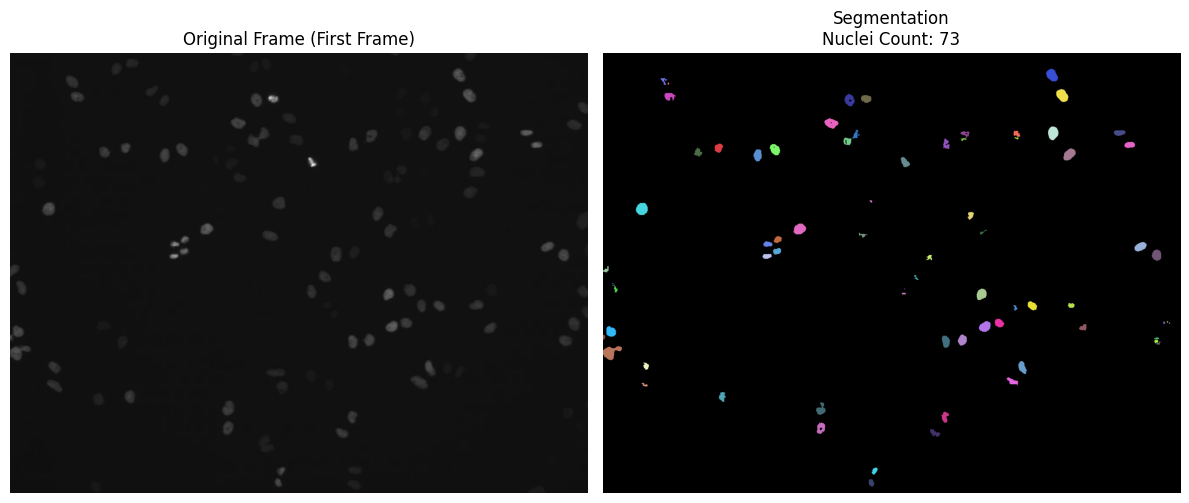

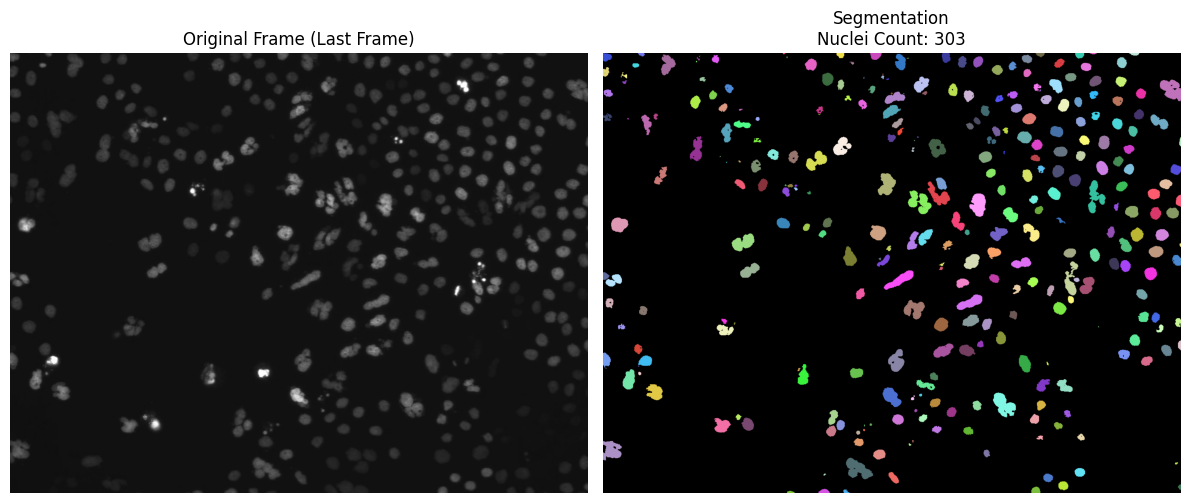

In [ ]:
VIDEO_PATH = "../data/processed/idr0013/LT0001_02/00004_01.mp4"
show_first_last_segmentation(VIDEO_PATH, threshold=50, min_area=5)



Video: ../data/processed/idr0013/LT0001_02/00006_01.mp4
First frame nuclei: 69
Last frame nuclei: 531
Ratio: 7.70


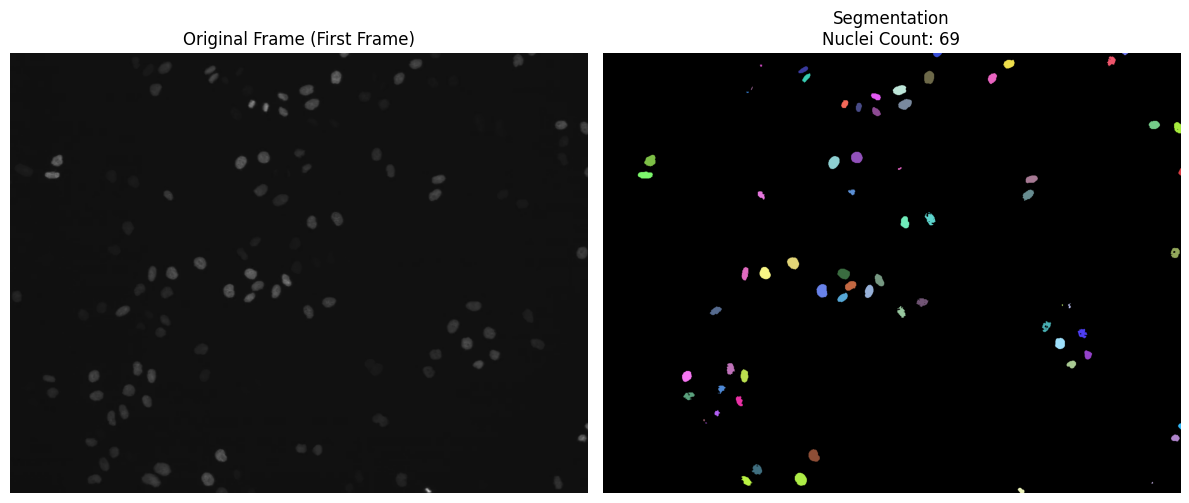

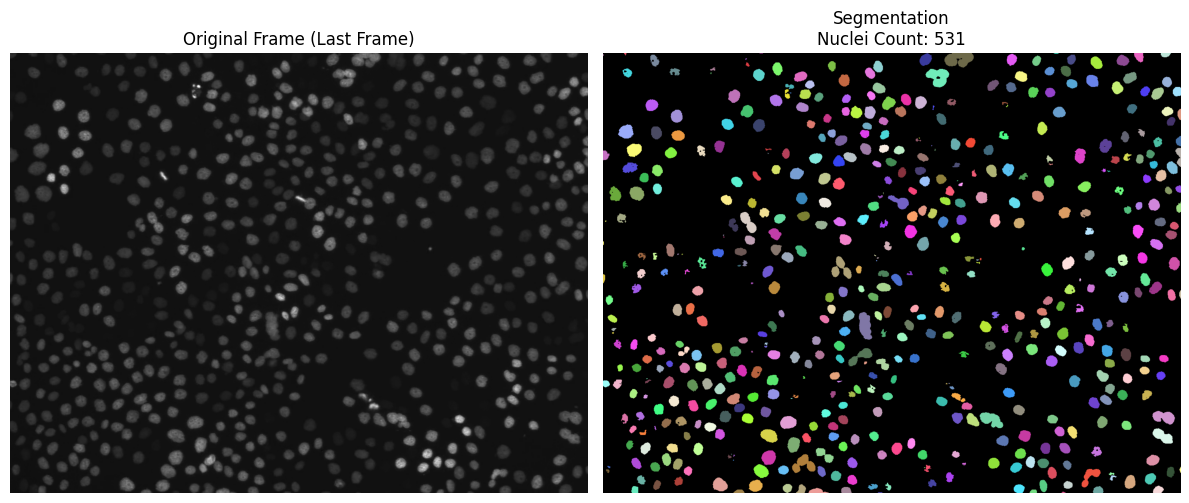

In [8]:
VIDEO_PATH = "../data/processed/idr0013/LT0001_02/00006_01.mp4"
show_first_last_segmentation(VIDEO_PATH, threshold=50, min_area=5)